In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
import cv2 as cv
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import cv2
from sklearn.metrics import confusion_matrix
import os

2025-09-25 14:34:59.806364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758810900.205205      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758810900.315687      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_path = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_path = '/kaggle/input/brain-tumor-mri-dataset/Testing'

print("type of Images in Train dataset"+str(os.listdir(train_path)))
print("type of Images in Test dataset"+str(os.listdir(test_path)))

type of Images in Train dataset['pituitary', 'notumor', 'meningioma', 'glioma']
type of Images in Test dataset['pituitary', 'notumor', 'meningioma', 'glioma']


pituitary images:


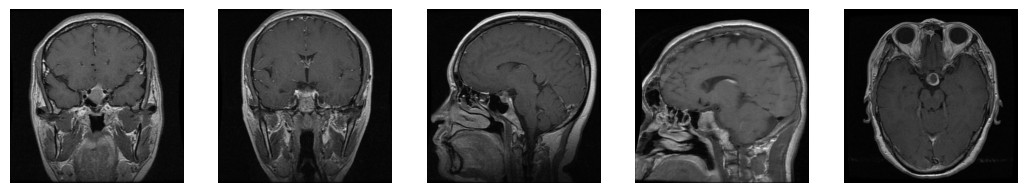

notumor images:


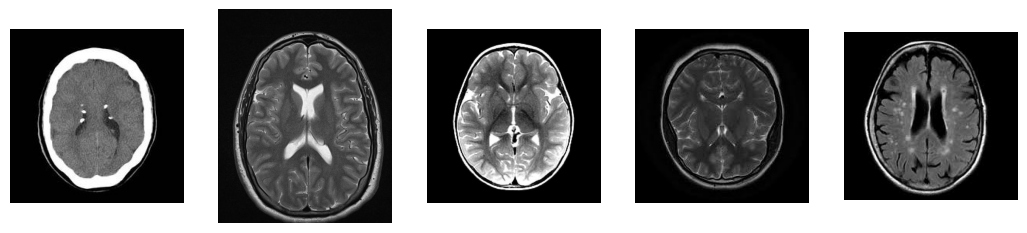

meningioma images:


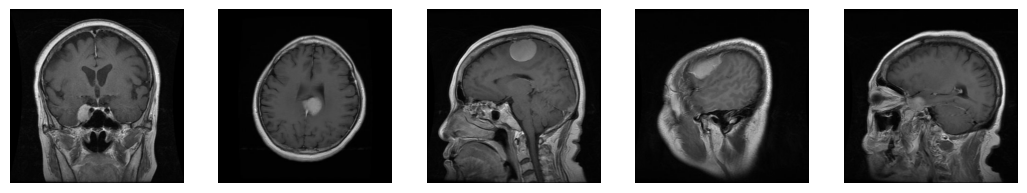

glioma images:


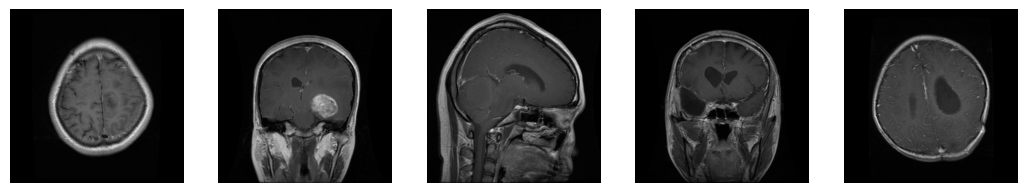

In [3]:

import matplotlib.pyplot as plt

rows, cols = (1, 5)


for category in os.listdir(train_path):
    print(f'{category} images:')
    category_path = os.path.join(train_path, category)
    
    fig = plt.figure(figsize=(13, 8))
    for i in range(rows * cols):
        fig.add_subplot(rows, cols, i + 1)
        
        # List image files in the specific category's directory
        image_files = os.listdir(category_path)
        if not image_files:
            continue
        
        # Select a random image file from the list
        random_image_id = np.random.choice(image_files)
        image = cv.imread(os.path.join(category_path, random_image_id))
        
        plt.imshow(image[:, :, ::-1])  # Convert BGR to RGB
        #plt.title(random_image_id)
        plt.axis('off')
    
    plt.show()


In [4]:
from tqdm import tqdm
class_names = ['pituitary', 'notumor', 'meningioma', 'glioma']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (198, 198)

In [5]:
def load_data():
    
    
    datasets = ['/kaggle/input/brain-tumor-mri-dataset/Training', '/kaggle/input/brain-tumor-mri-dataset/Testing']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                #image = cv2.cvtColor(image, cv2.COLOR_RGB2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [6]:
batch_size = 32 
epochs = 100
data_augmentation = True
num_classes = 4

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = False

n = 3

version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

In [7]:
(x_train, y_train), (x_test, y_test) = load_data()

Loading /kaggle/input/brain-tumor-mri-dataset/Training


100%|██████████| 1321/1321 [00:14<00:00, 90.54it/s]


Loading /kaggle/input/brain-tumor-mri-dataset/Testing


100%|██████████| 300/300 [00:03<00:00, 98.50it/s] 


In [8]:
print(model_type)

ResNet20v1


In [9]:
input_shape = x_train.shape[1:]
print(input_shape)

(198, 198, 3)


In [10]:
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [11]:
# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (5712, 198, 198, 3)
5712 train samples
1311 test samples
y_train shape: (5712,)


In [12]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [13]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [14]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [15]:
def resnet_v1(input_shape, depth, num_classes= 4):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=4):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [16]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping

if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])

model.summary()
print(model_type)

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'IntelImageClass_%s_model.{epoch:03d}.h5' % model_type

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

filepath = os.path.join(save_dir, model_name)

# Prepare callbacks
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',  
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6,
                               verbose=1)

# ✅ Add EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True,
                               verbose=1)

# Final callbacks list
callbacks = [checkpoint, lr_reducer, lr_scheduler, early_stopping]




I0000 00:00:1758811004.968385      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758811004.969164      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Learning rate:  0.001


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 198, 198,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 198, 198,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 198, 198,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 198, 198,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 198, 198,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 198, 198,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 198, 198,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 198, 198,  │      2,320 │ activation_1[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 198, 198,  │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 198, 198,  │          0 │ activation[0][0], │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 198, 198,  │          0 │ add[0][0]         │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 198, 198,  │      2,320 │ activation_2[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 198, 198,  │         64 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 198, 198,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 198, 198,  │      2,320 │ activation_3[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 198, 198,  │         64 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 198, 198,  │          0 │ activation_2[0][

 Total params: 283,012 (1.08 MB)

 Trainable params: 281,636 (1.07 MB)

 Non-trainable params: 1,376 (5.38 KB)

ResNet20v1


In [17]:
# Model training
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=100,
                    validation_data=(x_test, y_test),
                    shuffle=True,
                    callbacks=callbacks)

Learning rate:  0.001
Epoch 1/100


I0000 00:00:1758811033.583201      87 service.cc:148] XLA service 0x7d7214051e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758811033.584653      87 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758811033.584703      87 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758811035.817450      87 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758811047.854675      87 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.6592 - loss: 1.2063
Epoch 1: val_accuracy improved from -inf to 0.38215, saving model to /kaggle/working/saved_models/IntelImageClass_ResNet20v1_model.001.h5
179/179 ━━━━━━━━━━━━━━━━━━━━ 90s 313ms/step - accuracy: 0.6597 - loss: 1.2044 - val_accuracy: 0.3822 - val_loss: 3.4856 - learning_rate: 0.0010
Learning rate:  0.001
Epoch 2/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8357 - loss: 0.6036
Epoch 2: val_accuracy improved from 0.38215 to 0.55683, saving model to /kaggle/working/saved_models/IntelImageClass_ResNet20v1_model.002.h5
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 236ms/step - accuracy: 0.8357 - loss: 0.6035 - val_accuracy: 0.5568 - val_loss: 1.5703 - learning_rate: 0.0010
Learning rate:  0.001
Epoch 3/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.8569 - loss: 0.5339
Epoch 3: val_accuracy improved from 0.55683 to 0.69794, saving model to /kaggle/working/saved_models/IntelImageClass_ResNet20v1_model.

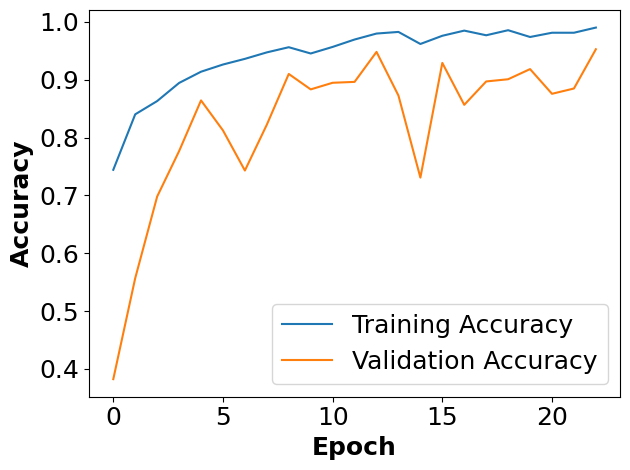

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Model Accuracy')
plt.ylabel('Accuracy',fontsize=18,weight='bold')
plt.xlabel('Epoch',fontsize=18,weight='bold')
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout() 
plt.show()

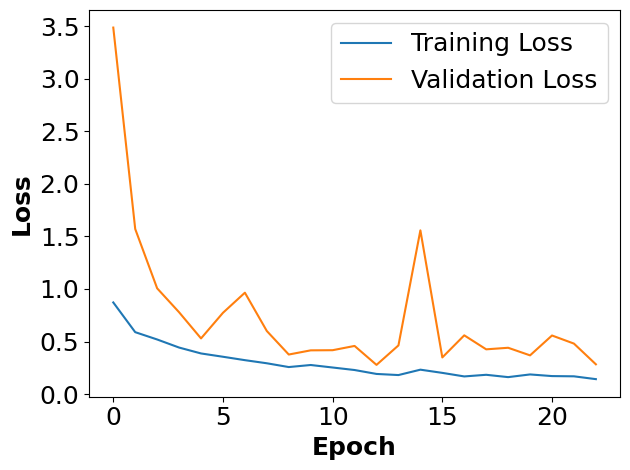

In [19]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
plt.ylabel('Loss',fontsize=18,weight='bold')
plt.xlabel('Epoch',fontsize=18,weight='bold')
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()  
plt.show()

In [20]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
# model.save('my_models')

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9634 - loss: 0.2380
Test loss: 0.2781352996826172
Test accuracy: 0.9481312036514282


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


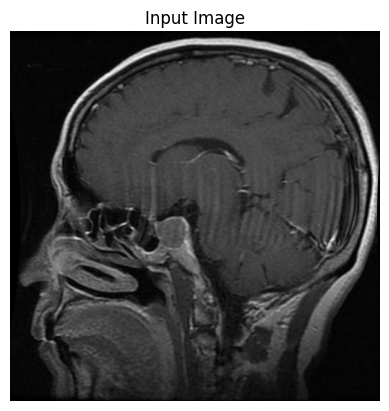

Predicted Disease:  pituitary
Class Probabilities:  [[9.9898440e-01 2.5504618e-05 7.3255709e-04 2.5761084e-04]]


In [21]:
image_path = '/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0007.jpg'
image = cv2.imread(image_path)
image = cv2.resize(image, (198, 198))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

predictions = model.predict(image)

predicted_class = np.argmax(predictions)

class_names = ['pituitary', 'notumor', 'meningioma', 'glioma']
predicted_disease = class_names[predicted_class]

plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.title("Input Image")
plt.axis('off')
plt.show()

highlighted_disease = f"\033[1m{predicted_disease}\033[0m"  

print("Predicted Disease: ", highlighted_disease)
print("Class Probabilities: ", predictions)

In [22]:
from sklearn.metrics import confusion_matrix

def calculate_metrics(model, X_train, y_train, X_test, y_test):
    # Predictions on training and test datasets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Convert predicted probabilities to binary predictions (0 or 1)
    y_train_pred_binary = np.argmax(y_train_pred, axis=1)
    y_test_pred_binary = np.argmax(y_test_pred, axis=1)
    y_train_binary = np.argmax(y_train, axis=1)
    y_test_binary = np.argmax(y_test, axis=1)
    train_confusion_matrix = confusion_matrix(y_train_binary, y_train_pred_binary)
    test_confusion_matrix = confusion_matrix(y_test_binary, y_test_pred_binary)



    # Extract TP, TN, FP, FN values from confusion matrices
    train_tp = train_confusion_matrix[1, 1]
    train_tn = train_confusion_matrix[0, 0]
    train_fp = train_confusion_matrix[0, 1]
    train_fn = train_confusion_matrix[1, 0]

    test_tp = test_confusion_matrix[1, 1]
    test_tn = test_confusion_matrix[0, 0]
    test_fp = test_confusion_matrix[0, 1]
    test_fn = test_confusion_matrix[1, 0]

    # Calculate ratios
    train_false_positive_rate = train_fp / (train_fp + train_tn)
    train_false_negative_rate = train_fn / (train_fn + train_tp)
    train_true_positive_rate = train_tp / (train_tp + train_fn)
    train_true_negative_rate = train_tn / (train_tn + train_fp)

    test_false_positive_rate = test_fp / (test_fp + test_tn)
    test_false_negative_rate = test_fn / (test_fn + test_tp)
    test_true_positive_rate = test_tp / (test_tp + test_fn)
    test_true_negative_rate = test_tn / (test_tn + test_fp)

    return {
        "Train False Positive Rate": train_false_positive_rate,
        "Train False Negative Rate": train_false_negative_rate,
        "Train True Positive Rate": train_true_positive_rate,
        "Train True Negative Rate": train_true_negative_rate,
        "Test False Positive Rate": test_false_positive_rate,
        "Test False Negative Rate": test_false_negative_rate,
        "Test True Positive Rate": test_true_positive_rate,
        "Test True Negative Rate": test_true_negative_rate,
    }

# Example usage:
metrics = calculate_metrics(model, x_train, y_train, x_test, y_test)
print(metrics)

179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step
{'Train False Positive Rate': 0.0007012622720897616, 'Train False Negative Rate': 0.0018832391713747645, 'Train True Positive Rate': 0.9981167608286252, 'Train True Negative Rate': 0.9992987377279102, 'Test False Positive Rate': 0.0, 'Test False Negative Rate': 0.0049504950495049506, 'Test True Positive Rate': 0.995049504950495, 'Test True Negative Rate': 1.0}


In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot encoded to label
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded to label

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred_classes,digits=4))


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
Classification Report:
               precision    recall  f1-score   support

           0     0.9631    0.9567    0.9599       300
           1     0.9710    0.9926    0.9817       405
           2     0.8980    0.8922    0.8951       306
           3     0.9525    0.9367    0.9445       300

    accuracy                         0.9481      1311
   macro avg     0.9462    0.9445    0.9453      1311
weighted avg     0.9479    0.9481    0.9480      1311



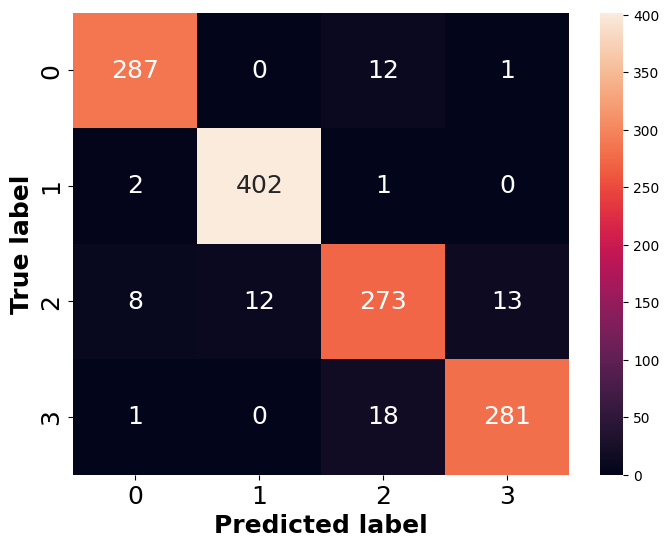

In [24]:
# Print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', annot_kws={"size": 18})
# plt.title('Confusion Matrix')
plt.ylabel('True label',fontsize=18,weight='bold')
plt.xlabel('Predicted label',fontsize=18,weight='bold')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()


Class names: ['pituitary', 'notumor', 'meningioma', 'glioma']
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


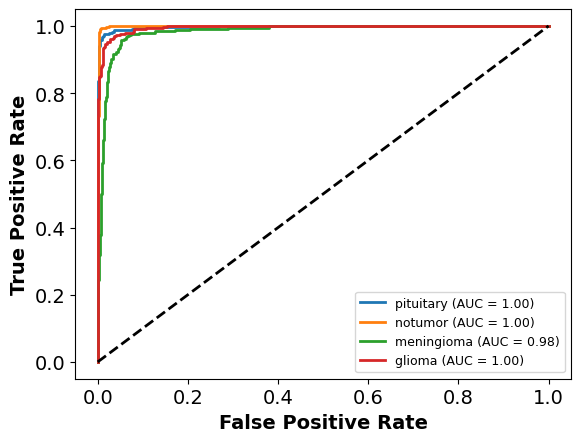

In [25]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Define the class names
class_names = ['pituitary', 'notumor', 'meningioma', 'glioma']

# If y_test is one-hot encoded, convert it back to labels
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

# Get unique class names from y_true
y_true = np.array(y_true)  # Convert to NumPy array for consistent handling

# Print the class names
print(f"Class names: {class_names}")

# Binarize the labels for multi-class ROC
y_test_binarized = label_binarize(y_true, classes=np.arange(len(class_names)))

# Ensure y_score has the correct shape
y_score = model.predict(x_test)

# Check if y_score has more classes than class_names
if y_score.shape[1] > len(class_names):
    y_score = y_score[:, :len(class_names)]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
# plt.figure(figsize=(10, 8))
# colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'yellow', 'pink', 'lightblue']

for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

# # Plot micro-average ROC curve
# plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle='--', linewidth=2,
#          label=f'micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize=14,weight='bold')
plt.ylabel('True Positive Rate',fontsize=14,weight='bold')
plt.legend(fontsize=9)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Class names: [0 1 2 3]


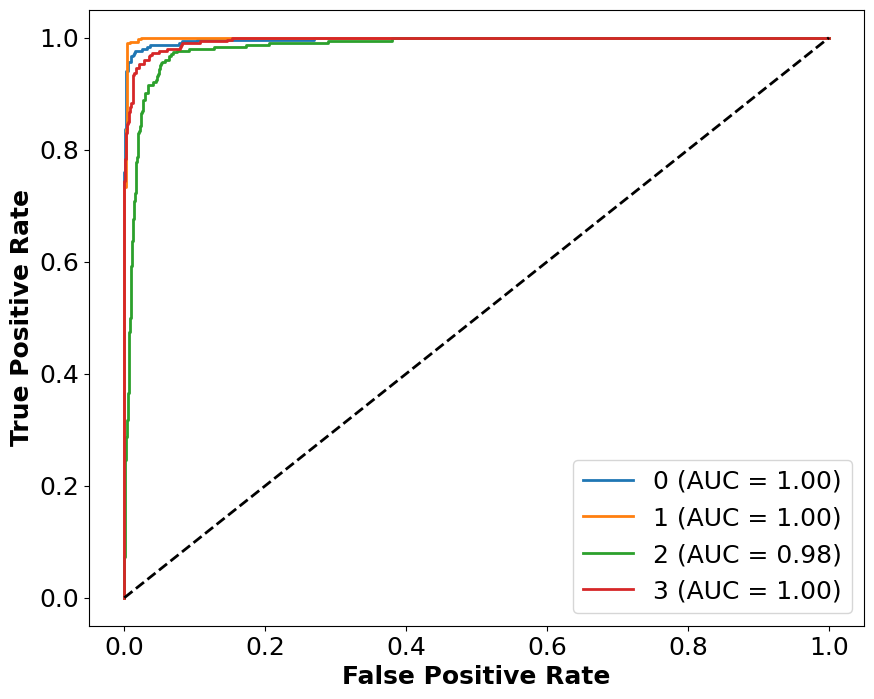

In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# If y_test is one-hot encoded, convert it back to labels
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

# Get unique class names from y_test
class_names = np.unique(y_true)
n_classes = len(class_names)

# Check if y_score has more classes than y_test
if y_score.shape[1] > n_classes:
    # Slice y_score to match the number of actual classes in y_test
    y_score = y_score[:, :n_classes]

# Print the class names
print(f"Class names: {class_names}")

# class_names = ['pituitary', 'notumor', 'meningioma', 'glioma']

# Binarize the labels for multi-class ROC
y_test_binarized = label_binarize(y_true, classes=class_names)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
# colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize=18,weight='bold')
plt.ylabel('True Positive Rate',fontsize=18,weight='bold')
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

